In [3]:
# import libraries
import fastai
from fastai import *
from fastai.text import * 
import pandas as pd
import numpy as np
from functools import partial
import io
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, classification_report, roc_curve, auc, roc_auc_score, hamming_loss, average_precision_score

In [4]:
print(fastai.__version__)

1.0.51


In [5]:
!wget https://storage.googleapis.com/aptsv_mock/DATA_HADM_CLEANED.csv.tar.gz
!tar zxvf DATA_HADM_CLEANED.csv.tar.gz

--2019-04-11 18:09:21--  https://storage.googleapis.com/aptsv_mock/DATA_HADM_CLEANED.csv.tar.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 2607:f8b0:400e:c07::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 80337665 (77M) [application/x-gzip]
Saving to: ‘DATA_HADM_CLEANED.csv.tar.gz’

DATA_HADM_CLEANED.c 100%[===================>]  76.62M  52.3MB/s    in 1.5s    

2019-04-11 18:09:23 (52.3 MB/s) - ‘DATA_HADM_CLEANED.csv.tar.gz’ saved [80337665/80337665]

DATA_HADM_CLEANED.csv


In [6]:
df = pd.read_csv('DATA_HADM_CLEANED.csv')
df.head()

,id,4019,4280,42731,41401,5849,25000,2724,51881,5990,...,c511,c412,c707,c348,c765,cE88,c571,c300,c733,text
0,117760,0,0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,admission date discharge date date birth sex s...
1,129030,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,admission date discharge date date birth sex s...
2,172040,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,admission date discharge date service medicine...
3,156170,0,1,1,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,admission date discharge date service medicine...
4,199180,0,1,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,admission date discharge date service ccu hist...


In [7]:
c = df.filter(like='c').columns.tolist()

In [8]:
df.drop(c, axis=1,inplace=True)
df.drop('id', axis=1,inplace=True)

In [9]:
train, valid = train_test_split(df, test_size = 0.2)
len(train), len(valid)

(42180, 10546)

In [10]:
df.to_csv("df.csv",index=False)#, header=None, index=False)

In [11]:
train.to_csv("train.csv", header=False, index=False)
valid.to_csv("valid.csv", header=False, index=False)

In [12]:
path=''

In [13]:
df.columns

Index(['4019', '4280', '42731', '41401', '5849', '25000', '2724', '51881',
       '5990', '53081', '2720', '2859', '2449', '486', '2851', '2762', '496',
       '99592', 'V5861', '5070', '0389', '5859', '40390', '311', '3051', '412',
       '2875', '41071', '2761', 'V4581', '4240', 'V1582', '5119', 'V4582',
       '40391', 'V290', '4241', '78552', 'V5867', '42789', '32723', '9971',
       '5845', '2760', '7742', '5180', 'V053', '4168', '49390', '2767',
       'text'],
      dtype='object')

In [14]:
lab = df.columns.tolist()[0:-1]

In [15]:
# Language model data
data_lm = TextLMDataBunch.from_csv(path, 'df.csv',label_cols=lab, text_cols=['text'])

In [16]:
# Classifier model data
data_clas = TextClasDataBunch.from_csv(path, 'df.csv', vocab=data_lm.train_ds.vocab, bs=32,label_cols=lab, text_cols=['text'])

In [17]:
data_lm.save('data_lm_export.pkl')
data_clas.save('data_clas_export.pkl')

In [18]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


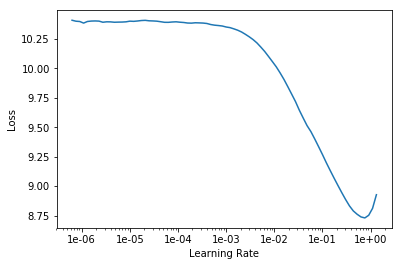

In [23]:
learn.lr_find()
learn.recorder.plot(skip_end=10)

In [24]:
learn.fit_one_cycle(1, 1e-2,moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.947878,3.779886,0.382815,24:18


In [25]:
learn.save('fit_head')
learn.load('fit_head')

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (42180 items)
x: LMTextList
xxbos admission date discharge date date birth sex service medicine allergies patient recorded known allergies drugs attending chief complaint lower extremity cellulitis major surgical invasive procedure paracentesis x5 intubation incision drainage left foot upper endoscopy sigmoidoscopy bronchoscopy broncheoalveolar lavage history present illness mr year old man history cirrhosis alcoholic hepatitis admitted due lle cellulitis started iv antibiotics time eventually broadened vanc zosyn left foot podiatry wound cultures left foot positive pansensitive klebsiella hospital course also complicated sbp given days treatment repeat diagnostic paracentesis negative patient began complaining worsening abodminal pain mental status began deteriorate also spiked fever subsequently bright red bowel movement context clinical change mr transferred micu care icu patient egd showed severe gastritis enteropathy one non 

In [26]:
learn.unfreeze()
learn.fit_one_cycle(10, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.641180,3.523966,0.407840,27:22
1,3.347990,3.323050,0.429657,27:20
2,3.217284,3.203426,0.442517,27:21
3,3.136537,3.127950,0.450653,27:22
4,3.115288,3.080927,0.456001,27:20
5,3.068339,3.045128,0.460350,27:17
6,2.966728,3.019067,0.463729,27:17
7,2.972884,3.000803,0.466080,27:18
8,2.852494,2.993196,0.467401,27:18
9,2.829775,2.992503,0.467548,27:17


In [27]:
learn.save_encoder('fine_tuned_enc')

### Data classifier

In [28]:
data_clas.show_batch()

text,target
xxbos admission date discharge date date birth sex f service surgery allergies patient recorded known allergies drugs attending chief complaint severe pancreatitis major surgical invasive procedure picc placement percutaneous tracheostomy history present illness year old female woke morning severe periumbilical abdominal pain nausea vomitting vomitted times reports blood pain became epigastric nature radiate stayed midline abdomen reports normal bowel movements diarrhea ruq pain usoh time denies concerns presented day vitals,4019;4280;5849;51881;5990;2859;2762;5119;42789
xxbos admission date discharge date date birth sex f service neurosurgery allergies penicillins attending chief complaint sudden onset headache major surgical invasive procedure angiogram x coiling aneurysm placement right frontal external ventricular drain history present illness patient yo khmer speaking rhw htn dm hypercholesterolemia developed sudden severe ha around pm last night per daughter lives patient usual self watching television suddenly complained severe headache grabbed daughter expressing pain also complained,4019;25000;5990;2720;2851;2762
xxbos admission date discharge date date birth sex f service medicine allergies penicillins imuran cephalosporins sulfa sulfonamide antibiotics reglan latex ampicillin lactose soy lentals beans attending chief complaint dyspnea shortness breath reason micu transfer dyspnea respiratory distress major surgical invasive procedure cardiac catheterization history present illness pleasant year old indian female complicated past medical history significant type iddm p revision renal pancraes transplants diastolic chf echo sleep disordered breathing l,4280;42731;5849;2449;2762;5859;412;2761;32723
xxbos admission date discharge date date birth sex service reason admission patient admitted hypotension history present illness patient year old gentleman history cadaveric renal transplant type diabetes coronary artery disease status post silent anteroseptal myocardial infarction recent ejection fraction recently admitted surgery service time treated diverticulitis acute renal failure secondary acute tubular necrosis treated ampicillin levaquin flagyl discharged rehabilitation patient presented emergency department rehabilitation decreased systolic blood pressures acute renal,4280;0389;5845
xxbos admission date discharge date date birth sex f service medicine allergies penicillins sulfa sulfonamide antibiotics iodine iodine containing tetanus codeine zyvox plaquenil vibramycin attending chief complaint chief complaint altered mental status fevers reason icu admission hypotension major surgical invasive procedure history present illness year old female pmh dm2 asthma pvd rheumatoid arthritis ulcerative colitis multiple non healing ulcers sacral decubitus ulcers presenting evaluation altered mental status fevers noted patient,4019;5849;2724;5990;2449;0389;311;49390


In [30]:
learn = text_classifier_learner(data_clas,AWD_LSTM, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc')
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


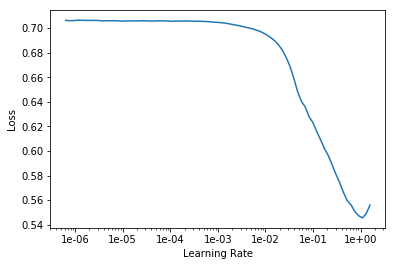

In [31]:
learn.lr_find()
learn.recorder.plot()

In [39]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,time
0,0.214971,0.211022,11:15


In [40]:
learn.save('first')

In [41]:
learn.load('first');

In [42]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,time
0,0.196819,0.184657,12:57


In [43]:
learn.save('second')

In [44]:
learn.load('second');

In [45]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,time
0,0.197925,0.180744,20:32


In [46]:
learn.save('third')
learn.load('third');

In [47]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,time
0,0.191020,0.173701,24:42
1,0.182383,0.172513,23:21


In [48]:
learn.save('fourth')

### Evaluate results


In [80]:
y_pred, y_true =  learn.get_preds()

In [81]:
f1_score(y_true, y_pred>0.35, average='micro')

0.5794276687526582

In [82]:
f1_score(y_true, y_pred>0.35, average='macro')

/home/oren/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.4319794273917511

In [83]:
f1_score(y_true, y_pred>0.35, average='weighted')

0.5264502900017759

In [85]:
roc_auc_score(y_true, y_pred)

0.8830364820356155

In [99]:
average_precision_score(y_true, y_pred)

0.4833601055598395

In [87]:
y_true = y_true.numpy()
scores = y_pred.numpy()

In [88]:
scores.shape, y_true.shape

((10546, 50), (10546, 50))

In [89]:
metrics = classification_report(y_true, scores>0.35, target_names=data_clas.valid_ds.classes)
print(metrics)

              precision    recall  f1-score   support

        4019       0.70      0.84      0.77      3979
        4280       0.73      0.77      0.75      2594
       42731       0.85      0.84      0.85      2487
       41401       0.79      0.83      0.81      2450
        5849       0.57      0.64      0.61      1800
       25000       0.64      0.77      0.70      1787
        2724       0.61      0.63      0.62      1773
       51881       0.58      0.55      0.57      1432
        5990       0.69      0.55      0.61      1325
       53081       0.66      0.55      0.60      1228
        2720       0.47      0.26      0.33      1130
        2859       0.25      0.00      0.00      1025
        2449       0.72      0.81      0.76      1004
         486       0.43      0.28      0.34       972
        2851       0.62      0.43      0.51       929
        2762       0.44      0.10      0.16       868
         496       0.51      0.30      0.38       829
       99592       0.63    

/home/oren/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/oren/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/home/oren/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)
